In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import json
import requests
from scipy.optimize import curve_fit
import scipy.stats as stats
import numpy as np
import warnings
import gmaps
from config import gkey
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

gmaps.configure(api_key=gkey)

In [3]:
covid_df = pd.read_csv(os.path.join("COVID","03-22-2020.csv"))
world_pop_df = pd.read_csv(os.path.join('GDP', 'world_countries_gdp.csv'))
median_age_df = pd.read_csv(os.path.join('Median Age', 'output','median_age.csv'))
life_expectancy = pd.read_csv(os.path.join('Life Expectancy','output','life_expectancy.csv'))
unemployment_rate = pd.read_csv(os.path.join('Unemployment Rate','output','unemployment_rate.csv'))
medical_expenditure = pd.read_csv(os.path.join("Medical Expenditure", "NHA indicators.csv"),encoding = 'ISO-8859-1')
poverty = pd.read_csv(os.path.join('Poverty','output','poverty.csv'))
literacy = pd.read_csv(os.path.join('Literacy_Rate','literacy_rate.csv'))
bed_density = pd.read_csv(os.path.join('Hospital_beds','beds_density.csv'))
gender_ratio = pd.read_csv(os.path.join('Gender Ratio','output','gender_ratio.csv'))

#number of countries in each csv

print(f"COVID-19 Countries: {covid_df['Country/Region'].nunique()}")
print(f"World Population Countries: {world_pop_df['country'].nunique()}")
print(f"Median Age Countries: {median_age_df['Country'].nunique()}")
print(f"Life Expectancy Countries: {life_expectancy['Country'].nunique()}")
print(f"Unemployment Rate Countries: {unemployment_rate['Country'].nunique()}")
print(f"Medical Expenditure Countries: {medical_expenditure['Countries'].nunique()}")
print(f"Poverty Countries: {poverty['Country'].nunique()}")
print(f"Literacy Countries: {literacy['Country'].nunique()}")
print(f"Bed Density Countries: {bed_density['Country'].nunique()}")
print(f"Gender Ratio Countries: {gender_ratio['Country'].nunique()}")


COVID-19 Countries: 183
World Population Countries: 218
Median Age Countries: 259
Life Expectancy Countries: 259
Unemployment Rate Countries: 259
Medical Expenditure Countries: 188
Poverty Countries: 259
Literacy Countries: 259
Bed Density Countries: 259
Gender Ratio Countries: 259


In [4]:
#get date only
#map takes in a function. So we use a temporary function (lambda)
covid_df['Last Update'] = covid_df['Last Update'].map(lambda x: x[0:10])

In [5]:
#clean data
aggregation_functions = {'Confirmed': 'sum',
                         'Deaths': 'sum',
                         'Recovered': 'sum',
                         'Latitude': 'first',
                         'Longitude': 'first'}
grouped_covid_df = covid_df.groupby(['Country/Region']).agg(aggregation_functions)

#grouped_covid_df.drop(['Latitude','Longitude'],1,inplace=True)
grouped_covid_df.rename(index = {"US":"United States","Taiwan*":"Taiwan"}, inplace=True)
grouped_covid_df.reset_index(inplace=True)
grouped_covid_df.rename(columns = {"Country/Region":"Country"}, inplace=True)
medical_expenditure.columns = ['Countries', '2017 Health Budget per Capita ($)']
#grouped_covid_df.query('Country_Region.str.contains("Congo")',engine='python',inplace=True)

#clean medical expenditure
medical_expenditure.rename(columns = {'Countries': 'Country'},inplace=True)


In [6]:
#clean data
grouped_world_pop_df = world_pop_df.groupby('country').sum()
grouped_world_pop_df.drop(['rank','unGDP'],1,inplace=True)
grouped_world_pop_df.rename(index = {"South Korea":"Korea, South","Bahamas":"The Bahamas"}, 
                            columns = {"imfGDP": "GDP","gdpPerCapita": "GDP Per Capita","pop":"Population"},
                            inplace=True)
grouped_world_pop_df.index.name = 'Country'
grouped_world_pop_df.reset_index(inplace=True)

In [7]:
clean_median_age_df = median_age_df.copy()
clean_median_age_df['Country'] = clean_median_age_df['Country'].str.replace(pat='Congo, Democratic Republic Of the',repl='Republic of the Congo',case=False)

clean_median_age_df.sort_values(by='Country',ascending=True,inplace=True)
clean_median_age_df.reset_index(drop=True,inplace=True)

In [8]:
merged_df = grouped_covid_df.merge(grouped_world_pop_df,how='outer',on='Country')
#merged_df.dropna(inplace=True)
merged_df.reset_index(drop=True,inplace=True)

In [9]:
complete_df = merged_df.merge(clean_median_age_df,how='outer',on='Country')
complete_df.sort_values(by='Country',ascending=True,inplace=True)
complete_df.reset_index(drop=True,inplace=True)
#complete_df.dropna(inplace=True)
#complete_df.reset_index(drop=True,inplace=True)

complete_df.head()

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,GDP,GDP Per Capita,Population,Median Age
0,Afghanistan,40.0,1.0,1.0,33.9391,67.7100,2.068200e+10,531.2838,38928.346,19.0
1,Akrotiri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,89.0,2.0,2.0,41.1533,20.1683,1.721000e+10,5980.2689,2877.797,33.4
3,Algeria,201.0,17.0,65.0,28.0339,1.6596,1.930560e+11,4402.5406,43851.044,28.3
4,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.1


In [10]:
#merge complete_df with bed_density
df_list = [bed_density,life_expectancy,unemployment_rate,medical_expenditure,poverty,literacy,gender_ratio]

for df in df_list:
    complete_df = complete_df.merge(df,how='outer',on='Country')

In [11]:
#fix this garbage data
complete_df['Country'] = complete_df['Country'].replace({'Congo':'Congo, Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'Congo (Brazzaville)':'Congo, Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'DR Congo':'Congo, Democratic Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'Congo (Kinshasa)':'Congo, Democratic Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'Democratic Republic of the Congo':'Congo, Democratic Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'Republic of the Congo':'Congo, Democratic Republic Of The'})
complete_df['Country'] = complete_df['Country'].str.replace(pat='andorra',repl='Andorra',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='The Bahamas',repl='Bahamas',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat=' and ',repl=' And ',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='of ',repl='Of ',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='United States of America',repl='United States',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='the ',repl='The ',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='the ',repl='The ',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat=', The',repl='',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Bolivia Plurinational States Of',repl='Bolivia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Brunei Darussalam',repl='Brunei',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cabo Verde',repl='Cape Verde',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cape Verde Republic of',repl='Cape Verde',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cote D\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cte d\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cote d\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cote d\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cote d\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Lao People\'s Democratic Republic',repl='Laos',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Micronesia \(Federated States of\)',repl='Micronesia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Micronesia, Federated States Of',repl='Micronesia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Burma',repl='Myanmar',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='North Korea',repl='Korea, North',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Russian Federation',repl='Russia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='North Macedonia',repl='Macedonia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='The Republic Of Macedonia',repl='Macedonia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Venezuela \(Bolivarian Republic of\)',repl='Venezuela',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Viet Nam',repl='Vietnam',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='United Republic Of Tanzania',repl='Tanzania',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Bolivia ',repl='Bolivia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Republic Of Moldova',repl='Moldova',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Republic Of Korea',repl='Korea, South',case=False)

In [12]:
#drop occupied Palestinian territory, holy see, oceans, and cruise
#complete_df.drop([287,114,115,11,16,35,121,193,240,66,283,297],axis=0,inplace=True)

complete_df.query('Country.str.contains("Bahama")',engine='python')

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,GDP,GDP Per Capita,Population,Median Age,Hospital Bed Per 1000 Population Rate,Life Expectancy (years),Unemployment Rate (%),2017 Health Budget per Capita ($),Poverty (% of Pop),Literacy Rate (% of Pop),Gender (% of male)
20,Bahamas,4.0,0.0,0.0,25.0343,-77.3963,NaN,NaN,NaN,32.3,2.9,72.9,10.1,NaN,9.3,NaN,48.9796
256,Bahamas,0.0,0.0,0.0,24.2500,-76.0000,1.371000e+10,34863.8504,393.244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,Bahamas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1772,NaN,NaN,NaN


In [13]:
aggregation_functions = {'Latitude': 'first',
                         'Longitude': 'first',
                         'Confirmed': 'sum',
                         'Deaths': 'sum',
                         'Recovered': 'sum',
                         'GDP': 'sum',
                         'GDP Per Capita': 'sum',
                         'Population': 'sum',
                         'Median Age': 'sum',
                         'Hospital Bed Per 1000 Population Rate': 'sum',
                         'Life Expectancy (years)': 'sum',
                         'Unemployment Rate (%)': 'sum',
                         '2017 Health Budget per Capita ($)': 'sum',
                         'Poverty (% of Pop)': 'sum',
                         'Literacy Rate (% of Pop)': 'sum',
                         'Gender (% of male)': 'sum'}


complete_df.fillna(0,inplace=True)
#replace blanks and change datatype to float
complete_df['Hospital Bed Per 1000 Population Rate'] = complete_df['Hospital Bed Per 1000 Population Rate'].replace('',0)
complete_df['Literacy Rate (% of Pop)'] = complete_df['Literacy Rate (% of Pop)'].replace('',0)
complete_df['2017 Health Budget per Capita ($)'] = complete_df['2017 Health Budget per Capita ($)'].replace('-',0)
complete_df['2017 Health Budget per Capita ($)'] = complete_df['2017 Health Budget per Capita ($)'].astype('float64')

In [14]:
#d.set_index('Country',inplace=True)
complete_df = complete_df.groupby('Country').aggregate(aggregation_functions)

In [15]:
complete_df['Population'] = (complete_df['Population'] * 1000).astype('int64')

In [16]:
complete_df.drop(['Holy See',
                  'Holy See (Vatican City)',
                  'Atlantic Ocean',
                  'Arctic Ocean',
                  'British Indian Ocean Territory',
                  'Indian Ocean',
                  'Pacific Ocean',
                  'Southern Ocean',
                  'Cruise Ship',
                  'World',
                  'European Union'],axis=0,inplace=True)

In [17]:
complete_df = complete_df[(complete_df.T != 0).any()]

In [18]:
complete_df.to_csv(os.path.join('Final Data','complete_data.csv'), index=True)

In [19]:
confirmed_df = complete_df.loc[complete_df["Confirmed"] > 199]
confirmed_df["Mortality Rate (%)"] = round((confirmed_df["Deaths"]/confirmed_df["Confirmed"])*100,2)
confirmed_df["Confirmed Per 100000"] = (confirmed_df["Confirmed"]/confirmed_df["Population"])*100000

confirmed_df.sort_values('Confirmed Per 100000')

,Latitude,Longitude,Confirmed,Deaths,Recovered,GDP,GDP Per Capita,Population,Median Age,Hospital Bed Per 1000 Population Rate,Life Expectancy (years),Unemployment Rate (%),2017 Health Budget per Capita ($),Poverty (% of Pop),Literacy Rate (% of Pop),Gender (% of male),Mortality Rate (%),Confirmed Per 100000
Country,,,,,,,,,,,,,,,,,,
India,20.5937,78.9629,396.0,7.0,27.0,3.257720e+12,2360.6592,1380004385,28.1,0.7,69.1,8.5,69.0,21.9,71.2,51.9231,1.77,0.028696
Indonesia,-0.7893,113.9213,514.0,48.0,29.0,1.208860e+12,4419.5818,273523615,30.5,1.2,73.2,5.4,115.0,10.9,95.4,50.0000,9.34,0.187918
Mexico,23.6345,-102.5528,251.0,2.0,4.0,1.297750e+12,10065.3245,128932753,28.6,1.5,76.3,3.4,495.0,46.2,94.9,48.9796,0.80,0.194675
Russia,61.5240,105.3188,367.0,0.0,16.0,1.667460e+12,11426.0880,145934462,39.8,8.2,71.3,5.2,586.0,13.3,99.7,46.2366,0.00,0.251483
Egypt,26.8206,30.8025,327.0,14.0,56.0,3.313600e+11,3238.0117,102334404,23.9,1.6,73.2,12.2,106.0,27.8,80.8,50.9804,4.28,0.319541
Philippines,12.8797,121.7740,380.0,25.0,17.0,3.890480e+11,3550.3210,109581078,23.7,1.0,69.6,5.7,133.0,21.6,96.3,50.2488,6.58,0.346775
Pakistan,30.3753,69.3451,776.0,5.0,5.0,0.000000e+00,1278.9308,220892340,24.1,0.6,68.4,6.0,45.0,29.5,57.9,51.2195,0.64,0.351302
Colombia,4.5709,-74.2973,231.0,2.0,3.0,3.528100e+11,6933.7648,50882890,30.4,1.5,76.2,9.3,459.0,28.0,94.7,49.4949,0.87,0.453984
Algeria,28.0339,1.6596,201.0,17.0,65.0,1.930560e+11,4402.5406,43851044,28.3,1.9,77.2,11.7,258.0,23.0,80.2,50.7389,8.46,0.458370


The r-squared is: 0.32716637171396207
The p-squared is: 4.171996102861595e-05


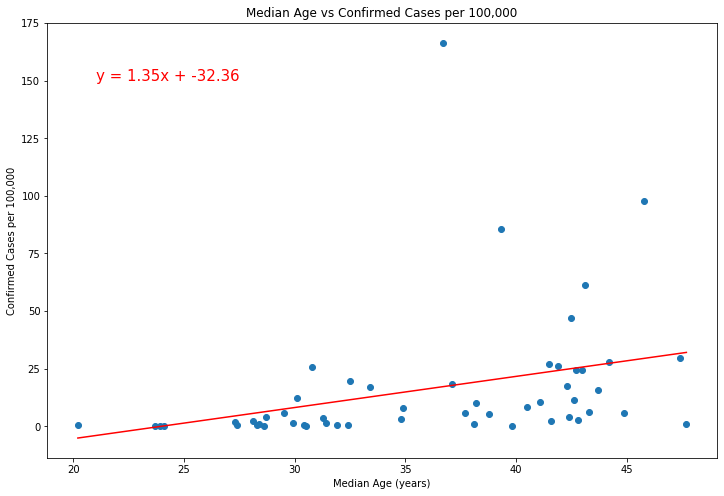

In [20]:
plt.figure(figsize=(12,8))

med_age = confirmed_df.groupby("Median Age")

confirmed_per100000 = med_age["Confirmed Per 100000"].mean()

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(confirmed_per100000.index, confirmed_per100000.values)
regress_values = confirmed_per100000.index * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(confirmed_per100000.index, confirmed_per100000.values)
plt.plot(confirmed_per100000.index,regress_values,"r-")
plt.annotate(line_eq,(21,150),fontsize=15,color="red")

plt.title("Median Age vs Confirmed Cases per 100,000")

plt.xlabel("Median Age (years)")
plt.ylabel("Confirmed Cases per 100,000")

print(f"The r-squared is: {rvalue}")
pvalue = stats.ttest_ind(confirmed_df["Median Age"], confirmed_df["Confirmed Per 100000"], equal_var=False)[1]
print(f"The p-squared is: {pvalue}")
plt.show()

The r-squared is: -0.18282677541124867
The p-squared is: 9.777354070501552e-48


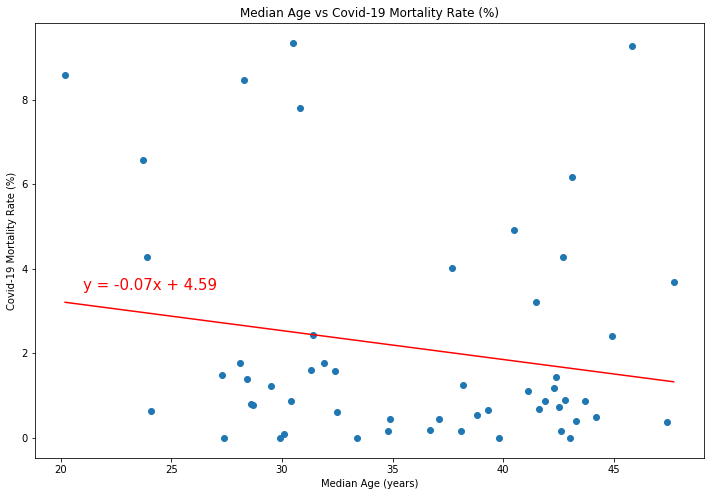

In [21]:
plt.figure(figsize=(12,8))

med_age = confirmed_df.groupby("Median Age")

mean_mortality = med_age["Mortality Rate (%)"].mean()

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(mean_mortality.index, mean_mortality.values)
regress_values = mean_mortality.index * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(mean_mortality.index, mean_mortality.values)
plt.plot(mean_mortality.index,regress_values,"r-")
plt.annotate(line_eq,(21,3.5),fontsize=15,color="red")

plt.title("Median Age vs Covid-19 Mortality Rate (%)")

plt.xlabel("Median Age (years)")
plt.ylabel("Covid-19 Mortality Rate (%)")

print(f"The r-squared is: {rvalue}")
pvalue = stats.ttest_ind(confirmed_df["Median Age"], confirmed_df["Mortality Rate (%)"], equal_var=False)[1]
print(f"The p-squared is: {pvalue}")

plt.show()

The r-squared is: -0.24506107949855785
The p-squared is: 0.0010140485436326886


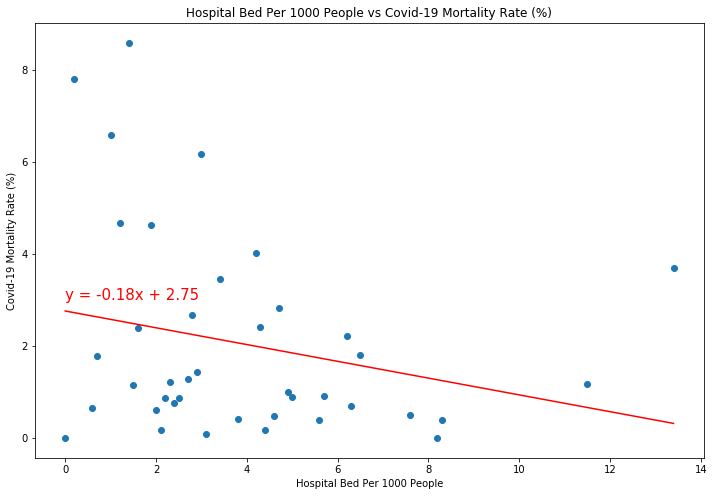

In [22]:
plt.figure(figsize=(12,8))

hospital_bed = confirmed_df.groupby("Hospital Bed Per 1000 Population Rate")

mean_mortality = hospital_bed["Mortality Rate (%)"].mean()

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(mean_mortality.index, mean_mortality.values)
regress_values = mean_mortality.index * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(mean_mortality.index, mean_mortality.values)
plt.plot(mean_mortality.index,regress_values,"r-")
plt.annotate(line_eq,(0,3),fontsize=15,color="red")

plt.title("Hospital Bed Per 1000 People vs Covid-19 Mortality Rate (%)")

plt.xlabel("Hospital Bed Per 1000 People")
plt.ylabel("Covid-19 Mortality Rate (%)")

print(f"The r-squared is: {rvalue}")
pvalue = stats.ttest_ind(confirmed_df["Hospital Bed Per 1000 Population Rate"], confirmed_df["Mortality Rate (%)"], equal_var=False)[1]
print(f"The p-squared is: {pvalue}")

plt.show()

The r-squared is: -0.18107695979339625
The p-squared is: 1.489583946000714e-09


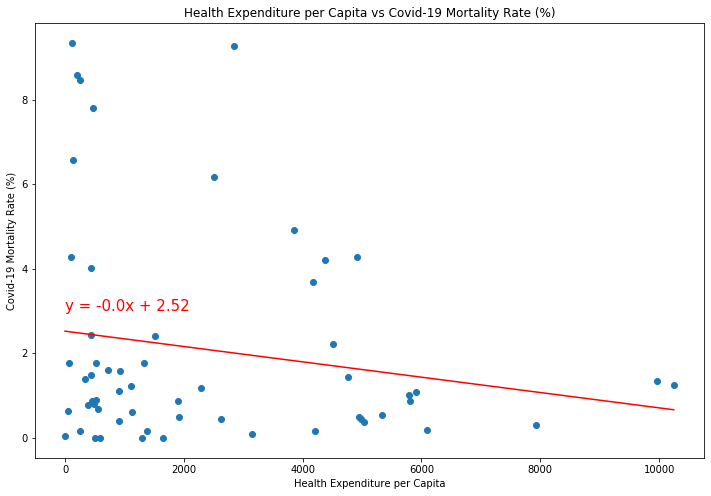

In [23]:
plt.figure(figsize=(12,8))

health_exp = confirmed_df.groupby("2017 Health Budget per Capita ($)")

mean_mortality = health_exp["Mortality Rate (%)"].mean()

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(mean_mortality.index, mean_mortality.values)
regress_values = mean_mortality.index * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(mean_mortality.index, mean_mortality.values)
plt.plot(mean_mortality.index,regress_values,"r-")
plt.annotate(line_eq,(0,3),fontsize=15,color="red")

plt.title("Health Expenditure per Capita vs Covid-19 Mortality Rate (%)")

plt.xlabel("Health Expenditure per Capita")
plt.ylabel("Covid-19 Mortality Rate (%)")

print(f"The r-squared is: {rvalue}")
pvalue = stats.ttest_ind(confirmed_df["2017 Health Budget per Capita ($)"], confirmed_df["Mortality Rate (%)"], equal_var=False)[1]
print(f"The p-squared is: {pvalue}")

plt.show()

In [81]:
locations = covid_df[['Latitude','Longitude']]

# Plost as a Hybrid map
fig = gmaps.figure(map_type="HYBRID")

# Create heat layer
confirmed_heat_layer = gmaps.heatmap_layer(locations, weights=covid_df['Confirmed'], 
                                 dissipating=False, max_intensity=1000,
                                 point_radius=4.5)

fig.add_layer(confirmed_heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [79]:
# Plost as a Hybrid map
fig = gmaps.figure(map_type="HYBRID")

# Create heat layer
deaths_heat_layer = gmaps.heatmap_layer(locations, weights=covid_df['Deaths'], 
                                 dissipating=False, max_intensity=100,
                                 point_radius=1.5)

fig.add_layer(deaths_heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [48]:
covid_df

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-22,67800,3144,59433,30.9756,112.2707
1,NaN,Italy,2020-03-22,59138,5476,7024,41.8719,12.5674
2,NaN,Spain,2020-03-22,28768,1772,2575,40.4637,-3.7492
3,NaN,Germany,2020-03-22,24873,94,266,51.1657,10.4515
4,NaN,Iran,2020-03-22,21638,1685,7931,32.4279,53.6880
5,France,France,2020-03-22,16018,674,2200,46.2276,2.2137
6,New York,US,2020-03-22,15793,117,0,42.1657,-74.9481
7,NaN,"Korea, South",2020-03-22,8897,104,2909,35.9078,127.7669
8,NaN,Switzerland,2020-03-22,7245,98,131,46.8182,8.2275
9,United Kingdom,United Kingdom,2020-03-22,5683,281,65,55.3781,-3.4360
